# **SpaceX  Falcon 9 first stage Landing Prediction**


# Introduction

In this project, I will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we know whether the first stage will land or not, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

To have a better understanding of the following sections, I made a brief summary of the main Falcon 9 components. The rocket is made of two stages and a payload. The first stage (also known as booster) carries the rocket to a pre-determined speed and altitude. The first stage is then separated from the rest and falls into the earth, while the second stage accelerates the payload to its target orbit. In order to be reused, the first stage has to perform a successfull vertical landing on the landing pad. Two components, mounted on the first stage, can help to accomplish this task: grid fins, which are used to control the booster descent, and four extensible landing legs.


# Section 1: Collecting the data


In this section, I will make a get request to the SpaceX API to collect data and I will also do some basic data wrangling and formating to make sure the requested data is clean and in the correct format. 

In [29]:
import requests
import pandas as pd
import numpy as np
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Below I define a series of helper functions that will help us to use the API to extract information using identification numbers in the launch data.

From the <code>rocket</code> column we would like to learn the booster name

In [4]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [5]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.


In [6]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.


In [7]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let us start requesting rocket launch data from SpaceX API with the following URL:


In [8]:
spacex_url="https://api.spacexdata.com/v4/launches"

In [9]:
response = requests.get(spacex_url)
response.status_code

200

Now we decode the response content as a Json using <code>.json()</code> and turn it into a Pandas dataframe using <code>.json_normalize()</code>


In [10]:
# Use json_normalize meethod to convert the json result into a dataframe
from pandas import json_normalize
dictr = response.json()
data = json_normalize(dictr)
# Print the first row
data.head(1)

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN


Notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.


In [11]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date']]

In [12]:
data.head()

,rocket,payloads,launchpad,cores,flight_number,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04


* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [13]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

Now, let's apply <code> getBoosterVersion</code> function method to get the booster version


In [14]:
# Call getBoosterVersion
getBoosterVersion(data)

the list has now been update 


In [21]:
BoosterVersion[1:10]

['Falcon 1',
 'Falcon 1',
 'Falcon 1',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9']

we can apply the rest of the  functions here:


In [14]:
# Call getLaunchSite
getLaunchSite(data)

In [15]:
# Call getPayloadData
getPayloadData(data)

In [15]:
# Call getCoreData
getCoreData(data)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.


In [17]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


Then, we need to create a Pandas data frame from the dictionary launch_dict.


In [18]:
# Create a data from launch_dict
data_df = pd.DataFrame.from_dict(launch_dict)

In [19]:
# Show the summary of the dataframe
data_df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1.0,False,False,False,None,NaN,0.0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1.0,False,False,False,None,NaN,0.0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1.0,False,False,False,None,NaN,0.0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1.0,False,False,False,None,NaN,0.0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0003,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,188,2022-10-20,Falcon 9,13260.0,VLEO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857
173,196,2022-11-01,Falcon 9,5100.0,MEO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857
174,199,2022-12-01,Falcon 9,NaN,PO,VAFB SLC 4E,None None,NaN,None,None,None,None,NaN,NaN,None,-120.610829,34.632093
175,200,2022-12-01,Falcon 9,NaN,SSO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857


### Filter the dataframe to only include `Falcon 9` launches


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the <code>BoosterVersion</code> column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called <code>data_falcon9</code>.


In [20]:
data_falcon9=data_df[data_df['BoosterVersion']!='Falcon 1']
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

C:\Users\gaeta\AppData\Local\Temp\ipykernel_20232\103109596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1.0,False,False,False,None,1.0,0.0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,169,2022-10-20,Falcon 9,13260.0,VLEO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857
173,170,2022-11-01,Falcon 9,5100.0,MEO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857
174,171,2022-12-01,Falcon 9,NaN,PO,VAFB SLC 4E,None None,NaN,None,None,None,None,NaN,NaN,None,-120.610829,34.632093
175,172,2022-12-01,Falcon 9,NaN,SSO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857


# Section 2: Data Wrangling


In this section, we will perform some Exploratory Data Analysis (EDA) to find some patterns in the data and determine what would be the label for training supervised models.

In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, <code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully landed on  a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed on a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.

We will mainly convert those outcomes into Training Labels with `1` means the booster successfully landed `0` means it was unsuccessful.

Before we start we can see below that some of the rows are missing values in our dataset.


In [21]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass       24
Orbit              1
LaunchSite         0
Outcome            0
Flights            5
GridFins           5
Reused             5
Legs               5
LandingPad        31
Block              5
ReusedCount        5
Serial             5
Longitude          0
Latitude           0
dtype: int64

We must deal with these missing values. The <code>LandingPad</code> column will retain None values to represent when landing pads were not used. Some other columns have exactly 5 missing values, corresponding to the most recent 5 launches, whose launch information is probabily missing.

In [22]:
data_falcon9[data_falcon9['Flights'].isnull()]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
172,169,2022-10-20,Falcon 9,13260.0,VLEO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857
173,170,2022-11-01,Falcon 9,5100.0,MEO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857
174,171,2022-12-01,Falcon 9,NaN,PO,VAFB SLC 4E,None None,NaN,None,None,None,None,NaN,NaN,None,-120.610829,34.632093
175,172,2022-12-01,Falcon 9,NaN,SSO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857
176,173,2022-12-01,Falcon 9,5100.0,MEO,CCSFS SLC 40,None None,NaN,None,None,None,None,NaN,NaN,None,-80.577366,28.561857


Here we will proceed by simply removing those columns:

In [23]:
data_falcon9=data_falcon9[data_falcon9['Flights'].notnull()]

In [24]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass       22
Orbit              1
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

### Dealing with Missing Values


We calculate below the mean for the <code>PayloadMass</code> using the <code>.mean()</code>. Then we use the mean and the <code>.replace()</code> function to replace `np.nan` values in the data with the mean calculated.


In [25]:
# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'].replace(np.nan,data_falcon9['PayloadMass'].mean(),inplace=True)

C:\Users\gaeta\AppData\Local\Temp\ipykernel_20232\1040625488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'].replace(np.nan,data_falcon9['PayloadMass'].mean(),inplace=True)


We can deal with the <code>Orbit</code> missing value by replacing it with the most frequent occurence:

In [26]:
data_falcon9['Orbit'].replace(np.nan,data_falcon9['Orbit'].describe()['top'],inplace=True)

C:\Users\gaeta\AppData\Local\Temp\ipykernel_20232\2280973196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Orbit'].replace(np.nan,data_falcon9['Orbit'].describe()['top'],inplace=True)


The number of missing values of the <code>PayLoadMass</code> and <code>Orbit</code> change to zero.


In [27]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

### Create a landing outcome label from Outcome column

In [28]:
landing_outcomes = data_falcon9['Outcome'].value_counts()

In [29]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 True RTLS
2 None None
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


We create a set of outcomes where the first stage did not land successfully:

In [30]:
bad_outcomes=set(landing_outcomes.keys()[[2,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

Using the <code>Outcome</code>, we create a list where the element is zero if the corresponding  row  in  <code>Outcome</code> is in the set <code>bad_outcome</code>; otherwise, it's one. Then we assign it to the variable <code>landing_class</code>:


In [31]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []
for row in data_falcon9['Outcome']:
    if row in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)
landing_class[0:8]

[0, 0, 0, 0, 0, 0, 1, 1]

This variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the  first stage did not land successfully; one means  the first stage landed Successfully

In [32]:
data_falcon9['Class']=landing_class
data_falcon9[['Class']].head(8)

C:\Users\gaeta\AppData\Local\Temp\ipykernel_20232\1698824859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Class']=landing_class


,Class
4,0
5,0
6,0
7,0
8,0
9,0
10,1
11,1


In [33]:
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,8191.07911,LEO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.00000,LEO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.00000,ISS,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.00000,PO,VAFB SLC 4E,False Ocean,1.0,False,False,False,None,1.0,0.0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.00000,GTO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B1004,-80.577366,28.561857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,164,2022-08-28,Falcon 9,13260.00000,VLEO,KSC LC 39A,True ASDS,2.0,True,True,True,5e9e3033383ecb075134e7cd,5.0,1.0,B1069,-80.603956,28.608058,1
168,165,2022-08-31,Falcon 9,13260.00000,VLEO,VAFB SLC 4E,True ASDS,7.0,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,6.0,B1063,-120.610829,34.632093,1
169,166,2022-09-17,Falcon 9,13260.00000,VLEO,CCSFS SLC 40,True ASDS,6.0,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,5.0,B1067,-80.577366,28.561857,1
170,167,2022-09-24,Falcon 9,13260.00000,VLEO,CCSFS SLC 40,True ASDS,4.0,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,0.0,B1072,-80.577366,28.561857,1


The success rate is

In [34]:
data_falcon9["Class"].mean()

0.8154761904761905

### Data Types

In [35]:
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights           float64
GridFins           object
Reused             object
Legs               object
LandingPad         object
Block             float64
ReusedCount       float64
Serial             object
Longitude         float64
Latitude          float64
Class               int64
dtype: object

In [36]:
data_falcon9['Flights'] = data_falcon9['Flights'].astype(int)
data_falcon9['GridFins'] = data_falcon9['GridFins'].astype(bool)
data_falcon9['Reused'] = data_falcon9['Reused'].astype(bool)
data_falcon9['Legs'] = data_falcon9['Legs'].astype(bool)
data_falcon9['ReusedCount'] = data_falcon9['ReusedCount'].astype(int)

C:\Users\gaeta\AppData\Local\Temp\ipykernel_20232\824547679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Flights'] = data_falcon9['Flights'].astype(int)
C:\Users\gaeta\AppData\Local\Temp\ipykernel_20232\824547679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['GridFins'] = data_falcon9['GridFins'].astype(bool)
C:\Users\gaeta\AppData\Local\Temp\ipykernel_20232\824547679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

We can now export it to a <b>CSV</b> for the next section.

In [37]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)

# Section 3: Exploring and Preparing Data

In this section we will perform Exploratory Data Analysis and Feature Engineering.

In [38]:
data_falcon9['LaunchSite'].value_counts()

CCSFS SLC 40    93
KSC LC 39A      49
VAFB SLC 4E     26
Name: LaunchSite, dtype: int64

In [39]:
data_falcon9['Orbit'].value_counts()

VLEO     55
ISS      32
GTO      31
LEO      14
PO       13
SSO      11
MEO       5
GEO       2
TLI       2
ES-L1     1
HEO       1
SO        1
Name: Orbit, dtype: int64

In [40]:
df=pd.read_csv("dataset_part_1.csv")
df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude,Class
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,84.500000,8191.079110,3.732143,4.196429,5.500000,-86.780776,29.514774,0.815476
std,48.641546,5144.814299,3.241707,1.385377,4.681471,14.519168,2.196342,0.389070
min,1.000000,330.000000,1.000000,1.000000,0.000000,-120.610829,28.561857,0.000000
25%,42.750000,3457.000000,1.000000,4.000000,1.000000,-80.603956,28.561857,1.000000
50%,84.500000,8191.079110,2.000000,5.000000,5.000000,-80.577366,28.561857,1.000000
75%,126.250000,13260.000000,5.250000,5.000000,9.000000,-80.577366,28.608058,1.000000
max,168.000000,15600.000000,13.000000,5.000000,13.000000,-80.577366,34.632093,1.000000


We will import the following libraries

In [41]:
# pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

### Exploratory Data Analysis


First, let's read the SpaceX dataset into a Pandas dataframe and print its summary


In [42]:
df=pd.read_csv('dataset_part_1.csv')
df.head(5)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,8191.07911,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.00000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.00000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.00000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.00000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [43]:
df.describe(include=['object'])

,Date,BoosterVersion,Orbit,LaunchSite,Outcome,LandingPad,Serial
count,168,168,168,168,168,142,168
unique,168,1,12,3,8,6,62
top,2010-06-04,Falcon 9,VLEO,CCSFS SLC 40,True ASDS,5e9e3032383ecb6bb234e7ca,B1060
freq,1,168,55,93,109,57,13


ANOVA, or Analysis of Variance, is a statistical method used to analyze the differences among group means in a sample. The F-statistic is a key component of ANOVA and is used to test the null hypothesis that the means of several groups are equal. Specifically, ANOVA assesses whether the variability between group means is greater than the variability within groups.

Here's a simplified breakdown of the concepts:

Between-group variability (explained variability): This is a measure of how much the means of different groups differ from each other. If this variability is significantly larger than what we would expect due to random chance, then it suggests that there are significant differences between at least two groups.

Within-group variability (unexplained variability): This is a measure of how much individual observations within each group differ from the group mean. If the within-group variability is relatively small compared to the between-group variability, it suggests that the observed differences in group means are not likely due to random chance.

F-statistic calculation: The F-statistic is calculated by taking the ratio of the between-group variability to the within-group variability. A high F-statistic suggests that the means of at least two groups are significantly different, indicating that there are likely meaningful differences among the groups.

Null hypothesis (H0): The null hypothesis in ANOVA states that there are no significant differences among the group means. The alternative hypothesis (Ha) is that at least one group mean is different from the others.

P-value: The p-value associated with the F-statistic is used to determine the statistical significance of the results. If the p-value is below a chosen significance level (e.g., 0.05), we reject the null hypothesis and conclude that there are significant differences among the group means.

In the context of feature selection using ANOVA F-statistics, variables are ranked based on their ability to discriminate between different classes or groups in a categorical target variable. The higher the F-statistic for a variable, the more likely it is to be informative for the classification task.

<p>Since ANOVA analyzes the difference between different groups of the same variable, the groupby function will come in handy. Because the ANOVA algorithm averages the data automatically, we do not need to take the average before hand.</p>

In [49]:
grouped_test=df[['Orbit', 'Class']].groupby(['Orbit'])
grouped_test.head(2)

,Orbit,Class
0,LEO,0
1,LEO,0
2,ISS,0
3,PO,0
4,GTO,0
5,GTO,0
6,ISS,1
12,ES-L1,1
17,PO,0
36,SSO,1


In [62]:
categories = df['Orbit'].unique()
groups = [grouped_test.get_group(category)['Class'] for category in categories]

[0      0
 1      0
 7      1
 16     1
 29     1
 37     1
 43     1
 117    1
 119    1
 122    1
 127    1
 130    1
 139    1
 151    1
 Name: Class, dtype: int64,
 2      0
 6      1
 10     0
 11     0
 13     0
 15     0
 19     1
 22     1
 26     1
 31     1
 35     1
 41     1
 47     0
 51     0
 59     0
 62     1
 63     1
 66     1
 69     1
 75     1
 78     1
 90     1
 93     1
 106    1
 111    1
 115    1
 118    1
 125    1
 138    1
 141    1
 155    1
 167    1
 Name: Class, dtype: int64,
 3      0
 17     0
 25     1
 33     1
 38     1
 42     1
 46     0
 53     1
 61     1
 91     1
 116    1
 121    1
 123    1
 Name: Class, dtype: int64,
 4      0
 5      0
 8      0
 9      0
 14     0
 18     0
 20     1
 21     1
 23     1
 24     0
 27     0
 28     1
 30     0
 32     1
 34     0
 39     1
 40     1
 44     1
 45     0
 49     1
 50     0
 52     1
 54     1
 55     1
 57     1
 67     0
 70     1
 94     1
 96     1
 112    1
 124    1
 Name: Class, dt

In [63]:
# ANOVA
from scipy.stats import f_oneway
f_val, p_val = f_oneway(*groups)
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 2.7238060260880146 , P = 0.0030373049458454777


In [73]:
for column in df.columns:
    num = df[column].unique().size
    print(f"{column} unique values: {num}")

FlightNumber unique values: 168
Date unique values: 168
BoosterVersion unique values: 1
PayloadMass unique values: 82
Orbit unique values: 12
LaunchSite unique values: 3
Outcome unique values: 8
Flights unique values: 13
GridFins unique values: 2
Reused unique values: 2
Legs unique values: 2
LandingPad unique values: 7
Block unique values: 5
ReusedCount unique values: 11
Serial unique values: 62
Longitude unique values: 3
Latitude unique values: 3
Class unique values: 2


each launch site is defined by a unique (lat, long), so late and long were not considered in the anova statistics. Regarding payload mass, since it is a countinuous variable, we'll use a different method for variable selection

In [70]:
grouping_variable=['Orbit',
'LaunchSite',
'Flights',
'GridFins',
'Reused',
'Legs',
#'LandingPad',
'Block',
'ReusedCount',
'Serial']
for variable in grouping_variable:
    grouped_test=df[[variable, 'Class']].groupby([variable])
    categories = df[variable].unique()
    groups = [grouped_test.get_group(category)['Class'] for category in categories]
    f_val, p_val = f_oneway(*groups)
    print( f"{variable} ANOVA results: F=", f_val, ", P =", p_val)  

Orbit ANOVA results: F= 2.7238060260880146 , P = 0.0030373049458454777
LaunchSite ANOVA results: F= 2.7807308406841287 , P = 0.06490085072013974
Flights ANOVA results: F= 2.0599680677231214 , P = 0.02260958911948897
GridFins ANOVA results: F= 141.24903061056224 , P = 5.8110572436645876e-24
Reused ANOVA results: F= 23.170870451862186 , P = 3.3141298248349923e-06
Legs ANOVA results: F= 161.51069603835364 , P = 2.8014434328238276e-26
Block ANOVA results: F= 26.144190988946946 , P = 9.393223943117124e-17
ReusedCount ANOVA results: F= 12.77477937529935 , P = 3.9027326507862654e-16
Serial ANOVA results: F= 5.902080575637226 , P = 1.014475426962067e-15


F-test passed for all the variables (F>F critical of the table) except for LaunchSite, using a significance level of 5% (http://www.socr.ucla.edu/Applets.dir/F_Table.html). For LaunchSite we failed to reject the null-hypothesis. Using a pie plot we can indeed see that there is no significant differences between the success rates among the three different sites.

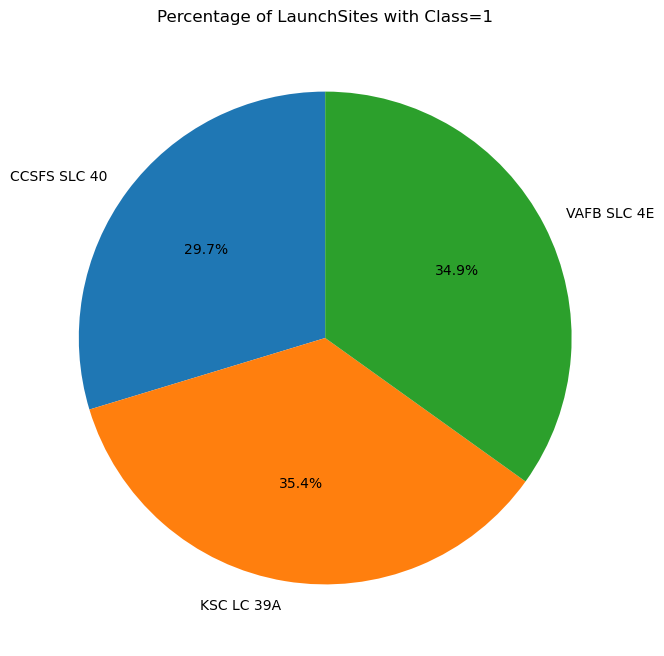

In [84]:
# Filter DataFrame for rows where Class is 1
df_class_1 = df[df['Class'] == 1]

# Group by LaunchSite and calculate the percentage of Class=1 for each LaunchSite
launchsite_percentages = df_class_1.groupby('LaunchSite').size() / df.groupby('LaunchSite').size() * 100

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(launchsite_percentages, labels=launchsite_percentages.index, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of LaunchSites with Class=1')
plt.show()

Moving on the Payload mass, by looking at the following box plot, it seems that the success rate is slightly above for greater payload masses, even though the overlap is significant. Anyway, the payload mass could potentially be a good predictor

<Axes: xlabel='Class', ylabel='PayloadMass'>

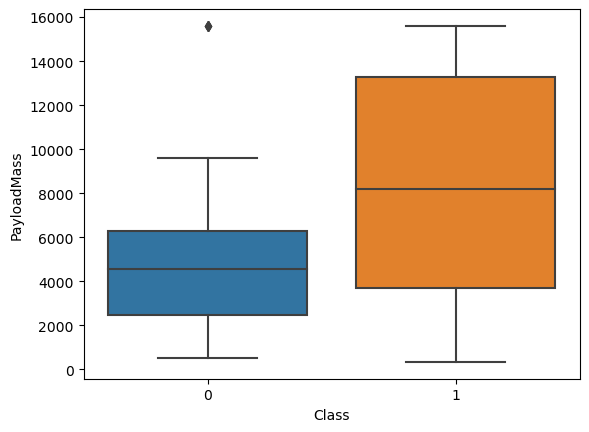

In [74]:
sns.boxplot(x="Class", y="PayloadMass", data=df)

### Features Engineering

Having some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction.